# Filipe Borba e Martim José
#### Hipótese: Jogadores com papel intermediário na rede tendem a apresentar uma queda de  desempenho.

In [1]:
import pandas as pd
import socnet as sn
import json
import scipy
import numpy as np
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

fp = open('network_cleaned_data.json', 'r')
players = json.load(fp)

In [2]:
#Numero de jogadores que jogaram os campeonatos
print(len(players))

238


# Construção do Grafo

Aqui podemos escolher fazer subgrafos a partir do número de campeonatos participados. Para uma visão geral, utilizar o valor 1.  
OBS: foram testados cortes com 4 e 6 campeonatos, mas as conclusões foram as mesmas.

Construimos o gráfico e plotamos.

In [3]:
camp_count = 1

def filter_players(camp_count, players):
    players_in = []
    for player in players:
        if len(players[player]["mean_rating_campeonato"]) >= camp_count:
                players_in.append(player)
    return players_in

players_in = filter_players(camp_count, players)

In [4]:
def create_gml(camp_count):
    gml = open("players{}.gml".format(camp_count), "w")
    gml.write("graph [\n  directed 1\n  weighted 1\n")
    players_in = []
    for player in players:
        if len(players[player]["mean_rating_campeonato"]) >= camp_count:
            players_in.append(player)
            gml.write('  node [\n    id {}\n    label "{}"\n  ]\n'.format(player, str(player)))
    for player in players:
        if len(players[player]["mean_rating_campeonato"]) >= camp_count:
            for team_mate, times_played in players[player]["team_mates"].items():
                if team_mate in players_in:
                    gml.write("  edge [\n    source {}\n    target {}\n    weight {}\n  ]\n".format(player, team_mate, times_played))
                else:
                    pass
    gml.write("]")
    gml.close()
create_gml(camp_count)

In [5]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'hover'
g = sn.load_graph('players{}.gml'.format(camp_count), has_pos=False)
g = g.to_undirected()
sn.show_graph(g, nlab=True)

Grafo sem direção, com cada aresta significando que um jogador jogou com outro.

# Análise do Grafo

Queremos analisar a relação entre a intermediação (betweenness) e o desempenho dos jogadores. Para isso, vamos utilizar a função betweenness_centrality do NetworkX. Além disso, precisamos do número de jogadores que o jogador jogou no mesmo time (evidenciando uma quebra do processo de construção de sinergia). Vamos também aproveitar e colocar no dataframe a média de rating por campeonato e quantos campeonatos jogou.

In [6]:
# Cálculo betwenness, rating médio, parceiros jogados, rating_medio por campeonato

def calc_relations(g, players):
    for n in g.nodes:
        g.nodes[n]['mean_rating'] = players[str(n)]["mean_rating"]
        g.nodes[n]['played_teams'] = players[str(n)]["teams"]
        g.nodes[n]['teammates_count'] = len(players[str(n)]["team_mates"])
    bet = nx.betweenness_centrality(g)
    # close = nx.closeness_centrality(g)
    mean_rating_camp = [list(players[str(p)]['mean_rating_campeonato'].values()) for p in g.nodes]


    df = pd.DataFrame({
        'id': [n for n in bet],
        'betweenness': [bet[n] for n in bet],
    #     'closeness': [close[n] for n in close],
        'mean_rating': [g.nodes[n]['mean_rating'] for n in g.nodes],
    #     'played_teams': [g.nodes[n]['played_teams'] for n in g.nodes],
    #     'played_teams_count': [len(g.nodes[n]['played_teams']) for n in g.nodes],
        'teammates_count': [g.nodes[n]['teammates_count'] for n in g.nodes],
        'mean_rating_camp': mean_rating_camp,
    })
    return df
df = calc_relations(g, players)

In [7]:
df['camps_played'] = df['mean_rating_camp'].str.len()
df.sort_values(by=['teammates_count'], ascending=False)

,id,betweenness,mean_rating,teammates_count,mean_rating_camp,camps_played
111,28,0.064980,0.881682,45,"[0.906, 0.946, 0.797, 0.818, 0.818]",5
114,25,0.030636,1.153833,37,"[1.25, 1.34, 1.18, 1.149, 0.995, 1.207, 1.064,...",9
41,20094,0.087771,0.869694,35,"[0.927, 0.754, 0.743, 1.011, 0.802, 0.773, 0.911]",7
112,63,0.023265,1.208000,34,"[1.188, 1.236, 1.052, 1.353, 1.241, 1.145]",6
32,120,0.036902,1.041109,32,"[1.109, 1.05, 0.826, 1.22, 0.955, 1.018, 1.015...",9
83,21571,0.015635,1.026896,31,"[0.878, 1.034, 1.113, 1.128, 0.894, 0.992, 1.09]",7
69,13652,0.058633,0.955432,31,"[0.965, 1.047, 0.85, 1.042, 1.087, 1.008, 0.83...",8
33,361,0.033524,0.876267,31,"[0.956, 0.684, 0.9, 0.702, 0.96]",5
113,1973,0.018130,0.971423,31,"[0.915, 1.017, 0.973, 1.142, 0.893]",5
12,17490,0.027313,1.058293,31,"[1.012, 1.041, 1.137, 1.044, 1.058]",5


In [8]:
df.describe()

,id,betweenness,mean_rating,teammates_count,camps_played
count,238.000000,238.000000,238.000000,238.000000,238.000000
mean,60070.613445,0.009409,0.901837,11.394958,2.878151
std,115984.552069,0.015183,0.170638,7.942535,2.217562
min,25.000000,0.000000,0.381000,3.000000,1.000000
25%,11211.750000,0.000001,0.818000,5.000000,1.000000
50%,21390.500000,0.001991,0.902110,9.000000,2.000000
75%,38414.750000,0.013404,1.013380,15.000000,4.750000
max,649387.000000,0.087771,1.394333,45.000000,9.000000


In [9]:
df.corr()

,id,betweenness,mean_rating,teammates_count,camps_played
id,1.000000,-0.042373,0.041384,-0.069690,-0.065711
betweenness,-0.042373,1.000000,0.134179,0.700573,0.563163
mean_rating,0.041384,0.134179,1.000000,0.305731,0.378523
teammates_count,-0.069690,0.700573,0.305731,1.000000,0.786349
camps_played,-0.065711,0.563163,0.378523,0.786349,1.000000


In [10]:
df["betweenness"].corr(df["mean_rating"])

0.13417912347787753

In [11]:
df["betweenness"].corr(df["teammates_count"])

0.70057324769290774

#### Observação
Observando o dataframe acima, foi possível verificar que muitos jogadores jogaram apenas 1 campeonato. Com isso, é visível um certo viés nos dados, visto que não sabemos se esses jogadores já possuem alguma sinergia ou não, por conta de ser apenas um campeonato pontual. Fizemos então, uma segunda análise com um recorte dos dados para apenas jogadores com 2 ou mais campeonatos jogados.

In [12]:
temp_df = df[df['camps_played'] >= 2]
temp_df.sort_values(by=['teammates_count'], ascending=False)

,id,betweenness,mean_rating,teammates_count,mean_rating_camp,camps_played
111,28,0.064980,0.881682,45,"[0.906, 0.946, 0.797, 0.818, 0.818]",5
114,25,0.030636,1.153833,37,"[1.25, 1.34, 1.18, 1.149, 0.995, 1.207, 1.064,...",9
41,20094,0.087771,0.869694,35,"[0.927, 0.754, 0.743, 1.011, 0.802, 0.773, 0.911]",7
112,63,0.023265,1.208000,34,"[1.188, 1.236, 1.052, 1.353, 1.241, 1.145]",6
32,120,0.036902,1.041109,32,"[1.109, 1.05, 0.826, 1.22, 0.955, 1.018, 1.015...",9
113,1973,0.018130,0.971423,31,"[0.915, 1.017, 0.973, 1.142, 0.893]",5
33,361,0.033524,0.876267,31,"[0.956, 0.684, 0.9, 0.702, 0.96]",5
12,17490,0.027313,1.058293,31,"[1.012, 1.041, 1.137, 1.044, 1.058]",5
69,13652,0.058633,0.955432,31,"[0.965, 1.047, 0.85, 1.042, 1.087, 1.008, 0.83...",8
83,21571,0.015635,1.026896,31,"[0.878, 1.034, 1.113, 1.128, 0.894, 0.992, 1.09]",7


In [13]:
temp_df.describe()

,id,betweenness,mean_rating,teammates_count,camps_played
count,146.000000,146.000000,146.000000,146.000000,146.000000
mean,52087.520548,0.014654,0.953063,15.075342,4.061644
std,115706.567555,0.017184,0.133850,8.074725,2.095060
min,25.000000,0.000000,0.572500,4.000000,2.000000
25%,9152.500000,0.001901,0.869958,8.250000,2.000000
50%,17928.000000,0.009407,0.956900,14.000000,4.000000
75%,29915.250000,0.023038,1.031719,20.000000,5.000000
max,649387.000000,0.087771,1.364500,45.000000,9.000000


In [14]:
temp_df.corr()

,id,betweenness,mean_rating,teammates_count,camps_played
id,1.000000,0.006291,0.153071,-0.019795,-0.012436
betweenness,0.006291,1.000000,-0.068358,0.617368,0.411703
mean_rating,0.153071,-0.068358,1.000000,0.144388,0.271714
teammates_count,-0.019795,0.617368,0.144388,1.000000,0.667485
camps_played,-0.012436,0.411703,0.271714,0.667485,1.000000


In [15]:
temp_df["betweenness"].corr(temp_df["mean_rating"])

-0.068358030797164862

In [16]:
temp_df["betweenness"].corr(temp_df["teammates_count"])

0.61736833644557509

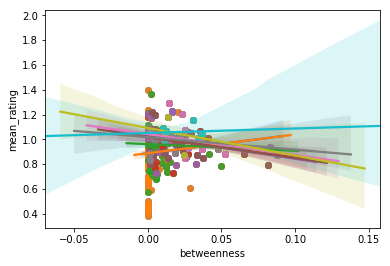

In [17]:
def corr_pvalue_calc(df):
    bet = []
    b_p = []
    b_slope = []
    # clo = []
    # c_p = []
    player_count = []
    ind = []
    for i in range(0, 10, 1):
        df2 = df[df['camps_played'] >= i]
        b_slope_value, _, _, b_p_value, _ = scipy.stats.linregress(df2["betweenness"], df2["mean_rating"])
    #     _, _, _, c_p_value, _ = scipy.stats.linregress(df2["closeness"], df2["mean_rating"])

        b_slope.append(round(b_slope_value,4))
        b_p.append(round(b_p_value,4))
    #     c_p.append(round(c_p_value,4))

        bet.append(df2["betweenness"].corr(df2["mean_rating"]))
    #     clo.append(df2["closeness"].corr(df2["mean_rating"]))

        player_count.append(len(df2))
        ind.append(i)
        sns.regplot(x="betweenness", y="mean_rating", data=df2);
    return bet, b_p, b_slope, player_count, ind

bet, b_p, b_slope, player_count, ind = corr_pvalue_calc(df)

In [18]:
# res = pd.DataFrame({'camps_played':ind, 'betweenness_corr':bet, 'betweenness p-value': b_p, 'closeness_corr':clo, 'closeness p-value': c_p})
res = pd.DataFrame({'more_than_x_camps_played':ind, 'betweenness_corr':bet, 'betweenness p-value': b_p, "total_player_count": player_count, 'angular coef': b_slope})
res

,more_than_x_camps_played,betweenness_corr,betweenness p-value,total_player_count,angular coef
0,0,0.134179,0.0386,238,1.5080
1,1,0.134179,0.0386,238,1.5080
2,2,-0.068358,0.4123,146,-0.5325
3,3,-0.253123,0.0149,92,-1.6308
4,4,-0.290908,0.0108,76,-1.8096
5,5,-0.296221,0.0216,60,-1.7342
6,6,-0.297966,0.0921,33,-1.6869
7,7,-0.232693,0.2853,23,-1.0094
8,8,-0.386024,0.2410,11,-2.2171
9,9,0.078609,0.8823,6,0.3597


Observando a correlação e o coeficiente angular, nota-se uma relação negativa entre o betweenness e o desempenho médio, porém o p-value está muito alto, indicando que a variável não será tão significativa para o modelo.

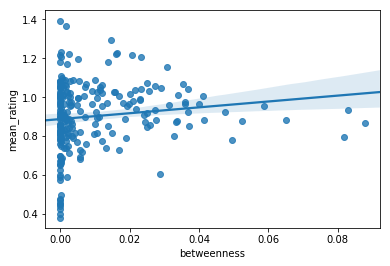

In [19]:
df0 = df[df['camps_played'] >= 0]
sns.regplot(x="betweenness", y="mean_rating", data=df0);

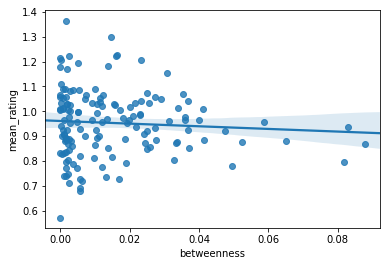

In [20]:
df2 = df[df['camps_played'] >= 2]
sns.regplot(x="betweenness", y="mean_rating", data=df2);

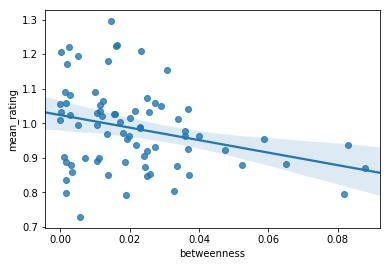

In [21]:
df4 = df[df['camps_played'] >= 4]
sns.regplot(x="betweenness", y="mean_rating", data=df4);

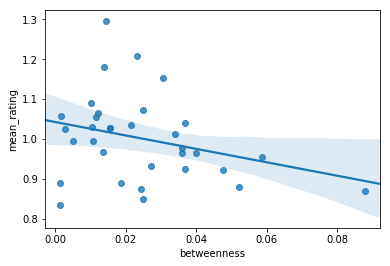

In [22]:
df6 = df[df['camps_played'] >= 6]
sns.regplot(x="betweenness", y="mean_rating", data=df6);

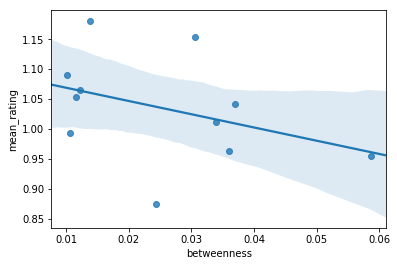

In [23]:
df8 = df[df['camps_played'] >= 8]
sns.regplot(x="betweenness", y="mean_rating", data=df8);

## Recorte: jogadores com apenas mais de dois campeonatos

Dada a situação de muitos jogadores com apenas um campeonato, fizemos um recorte daqueles que jogaram 2 ou mais. Isso muda o modo que o betweenness é calculado, podendo afetar o resultado final. Apesar disso, as conclusões foram parecidas: p-value alto e relação negativa de betweenness e desempenho.

In [24]:
camp_count = 2
create_gml(camp_count)
g = sn.load_graph('players{}.gml'.format(camp_count), has_pos=False)
g = g.to_undirected()
sn.show_graph(g, nlab=True)

In [25]:
df = calc_relations(g, players)
df['camps_played'] = df['mean_rating_camp'].str.len()
df.sort_values(by=['teammates_count'], ascending=False)

,id,betweenness,mean_rating,teammates_count,mean_rating_camp,camps_played
86,28,0.074964,0.881682,45,"[0.906, 0.946, 0.797, 0.818, 0.818]",5
89,25,0.038311,1.153833,37,"[1.25, 1.34, 1.18, 1.149, 0.995, 1.207, 1.064,...",9
34,20094,0.062004,0.869694,35,"[0.927, 0.754, 0.743, 1.011, 0.802, 0.773, 0.911]",7
87,63,0.024825,1.208000,34,"[1.188, 1.236, 1.052, 1.353, 1.241, 1.145]",6
26,120,0.037181,1.041109,32,"[1.109, 1.05, 0.826, 1.22, 0.955, 1.018, 1.015...",9
88,1973,0.020584,0.971423,31,"[0.915, 1.017, 0.973, 1.142, 0.893]",5
27,361,0.021028,0.876267,31,"[0.956, 0.684, 0.9, 0.702, 0.96]",5
10,17490,0.025949,1.058293,31,"[1.012, 1.041, 1.137, 1.044, 1.058]",5
55,13652,0.024008,0.955432,31,"[0.965, 1.047, 0.85, 1.042, 1.087, 1.008, 0.83...",8
63,21571,0.020812,1.026896,31,"[0.878, 1.034, 1.113, 1.128, 0.894, 0.992, 1.09]",7


In [26]:
df.describe()

,id,betweenness,mean_rating,teammates_count,camps_played
count,146.000000,146.000000,146.000000,146.000000,146.000000
mean,52087.520548,0.011734,0.953063,15.075342,4.061644
std,115706.567555,0.015548,0.133850,8.074725,2.095060
min,25.000000,0.000000,0.572500,4.000000,2.000000
25%,9152.500000,0.000616,0.869958,8.250000,2.000000
50%,17928.000000,0.005085,0.956900,14.000000,4.000000
75%,29915.250000,0.019887,1.031719,20.000000,5.000000
max,649387.000000,0.083469,1.364500,45.000000,9.000000


In [27]:
df.corr()

,id,betweenness,mean_rating,teammates_count,camps_played
id,1.000000,0.001544,0.153071,-0.019795,-0.012436
betweenness,0.001544,1.000000,0.003067,0.657993,0.438464
mean_rating,0.153071,0.003067,1.000000,0.144388,0.271714
teammates_count,-0.019795,0.657993,0.144388,1.000000,0.667485
camps_played,-0.012436,0.438464,0.271714,0.667485,1.000000


In [28]:
df["betweenness"].corr(df["mean_rating"])

0.0030666653775582244

In [29]:
df["betweenness"].corr(df["teammates_count"])

0.65799262508831735

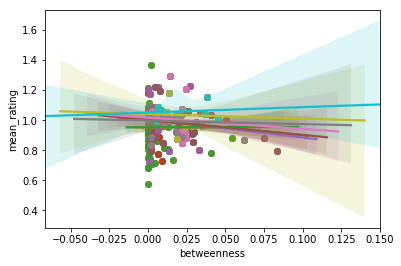

In [30]:
bet, b_p, b_slope, player_count, ind = corr_pvalue_calc(df)

In [31]:
res = pd.DataFrame({'more_than_x_camps_played':ind, 'betweenness_corr':bet, 'betweenness p-value': b_p, "total_player_count": player_count, 'angular coef': b_slope})
res

,more_than_x_camps_played,betweenness_corr,betweenness p-value,total_player_count,angular coef
0,0,0.003067,0.9707,146,0.0264
1,1,0.003067,0.9707,146,0.0264
2,2,0.003067,0.9707,146,0.0264
3,3,-0.139412,0.1850,92,-0.9997
4,4,-0.174246,0.1322,76,-1.2338
5,5,-0.160408,0.2208,60,-0.9967
6,6,-0.103607,0.5661,33,-0.7487
7,7,-0.040384,0.8548,23,-0.2338
8,8,-0.048785,0.8867,11,-0.3101
9,9,0.114792,0.8286,6,0.3597


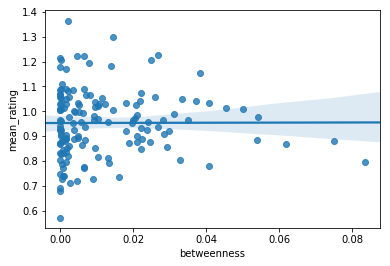

In [32]:
df2 = df[df['camps_played'] >= 2]
sns.regplot(x="betweenness", y="mean_rating", data=df2);

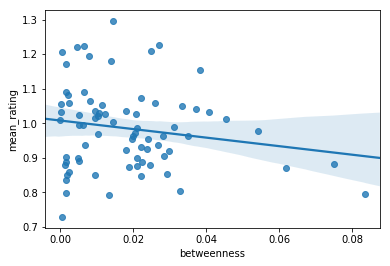

In [33]:
df4 = df[df['camps_played'] >= 4]
sns.regplot(x="betweenness", y="mean_rating", data=df4);

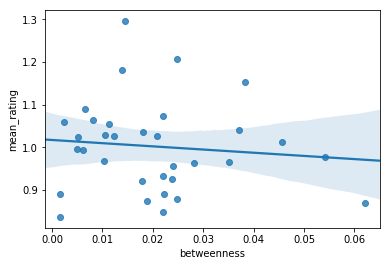

In [34]:
df6 = df[df['camps_played'] >= 6]
sns.regplot(x="betweenness", y="mean_rating", data=df6);